<a href="https://colab.research.google.com/github/awjans/CopilotForPRsAdoption/blob/main/scripts/AIDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection/Cleaning Overview
1. **PR identification**
   * Queried GitHub via GraphQL for PRs whose description contained the phrase **“Generated by Copilot”** or any of the marker tags:

     * `copilot:summary`
     * `copilot:walkthrough`
     * `copilot:poem`
     * `copilot:all`

2. **Scope**
   * Collected **18,256 PRs** from **146 early-adopter repositories** during **March 2023 – August 2023**.

3. **Control set**
   * For the same repositories, gathered **54,188 PRs** that did **not** contain any Copilot marker.
   * These served as the **untreated (control) group** for the **RQ2 comparison**.

4. **Bot filtering**
   * Removed PRs and comments authored by bots using the **high-precision method** of **Golzadeh et al. (2022)**, which included:
     * (i) Usernames ending with “bot”
     * (ii) A curated list of **527 known bot accounts**

5. **Revision extraction (RQ3)**
   * From the **18,256 Copilot-generated PRs**, retrieved the full **edit history** of PR descriptions.
   * Identified **1,437 revisions** where developers **edited the AI-suggested content**.

In [300]:
# Toggle to TRUE to limit dataset, else process entire dataset
TEST_MODE = False
# Toggle to TRUE to reload from disk, else do the preprocessing
RELOAD = True

In [301]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [343]:
import os

DATA_FOLDER = '/content/drive/MyDrive/AIDev_shared'
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

MODIFIER = '_TEST' if TEST_MODE else ''

METRICS_PKL = os.path.join(DATA_FOLDER, f'metrics_ai{MODIFIER}.pkl')
METRICS_CSV = os.path.join(DATA_FOLDER, f'metrics_ai{MODIFIER}.csv')
REPOS_PKL = os.path.join(DATA_FOLDER, f'repos_ai{MODIFIER}.pkl')

OUTPUT_CSV_TEMPLATE = os.path.join(DATA_FOLDER, "treatment_metrics_{AGENT}{MODIFIER}.csv")

HUMAN_METRICS_PKL = os.path.join(DATA_FOLDER, f'metrics_hu{MODIFIER}.pkl')

In [303]:
import asyncio
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import datetime
from dateutil import parser
from google.colab import userdata
from urllib.parse import urlparse
import time
import random
from itertools import cycle
from google.colab import userdata
from dateutil import parser
from urllib.parse import urlparse

# **First**, Define the URLs of the AIDev Parquet Files that we are intersted in.

In [304]:
pull_request_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/all_pull_request.parquet'
pr_comments_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_comments.parquet'
pr_commits_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_commits.parquet'
pr_commit_details_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_commit_details.parquet'
pr_reviews_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_reviews.parquet'
pr_review_comments_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_review_comments.parquet'
pr_task_type_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/pr_task_type.parquet'
repository_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/all_repository.parquet'
user_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/user.parquet'
human_pull_request_file_url = 'https://huggingface.co/datasets/hao-li/AIDev/resolve/main/human_pull_request.parquet'

# **Second**, We need to load the data from the URLs (15s)

### Load Parquet Files

In [305]:
"""
Load the Parquet file into a Pandas DataFrame from the file URL.
"""
def load_data(url: str):
  import pandas as pd # Import pandas inside the function
  try:
    # For Parquet files:
    df = pd.read_parquet(url)

    return df
  except Exception as e:
      print(f"Error loading data: {e}")
      print("Please ensure the URL is correct and the file is publicly accessible.")
      return None # Return None in case of an error

In [306]:
if not RELOAD:
  # Load the data from the URLs
  pull_request = load_data(pull_request_file_url)
  pr_comments = load_data(pr_comments_file_url)
  pr_commits = load_data(pr_commits_file_url)
  pr_commit_details = load_data(pr_commit_details_file_url)
  pr_reviews = load_data(pr_reviews_file_url)
  pr_review_comments = load_data(pr_review_comments_file_url)
  pr_task_type = load_data(pr_task_type_file_url)
  repository = load_data(repository_file_url)
  user = load_data(user_file_url)

## Create a Copy of Pull_Requests & Data Cleaning

1. **Copies DataFrames:** It creates copies of the pull_request and repository DataFrames and assigns them to metrics and repos respectively. This is a good practice to avoid modifying the original loaded data.
2. **Renames Columns:** It renames the 'id' column to 'pr_id' in the metrics DataFrame and to 'repo_id' in the repos DataFrame. This is done to prepare for merging these DataFrames later.
3. **Filters Open Pull Requests:** It removes pull requests that are still open by filtering out rows where the 'closed_at' column has a missing value (NaN).
4. **Converts Timestamps:** It converts the 'created_at' and 'closed_at' columns in the metrics DataFrame to datetime objects. This allows for easier time-based calculations.
5. **Filters Repositories:** It removes repositories from the repos DataFrame that do not have any closed pull requests in the metrics DataFrame.
6. **Gets Repository Creation Dates:** For the remaining repositories, it calls the get_repo_created_at function (defined in a previous cell) to fetch the creation date of each repository from the GitHub API and stores it in a new column 'repo_created_at'.
7. **Filters Repositories with Creation Dates:** It removes repositories where the 'repo_created_at' could not be retrieved.

In [307]:
import os, time, random, requests, pandas as pd
from datetime import datetime
from itertools import cycle # Import cycle

if not RELOAD:
  # Copy raw data
  metrics = pull_request.copy()
  repos = repository.copy()

  # === BASIC CLEANUP ===
  metrics = metrics.rename(columns={'id': 'pr_id'})
  repos = repos.rename(columns={'id': 'repo_id', 'url': 'repo_url'})

  print(f"Total PRs before filtering: {len(metrics):,}")
  metrics = metrics[metrics['closed_at'].notna()]
  print(f"Closed PRs retained: {len(metrics):,}")

  metrics['created_at'] = pd.to_datetime(metrics['created_at'], errors='coerce')
  metrics['closed_at'] = pd.to_datetime(metrics['closed_at'], errors='coerce')

  print(f"Total repos before filtering: {len(repos):,}")
  repos = repos[repos['repo_id'].isin(metrics['repo_id'])]
  print(f"Repos with ≥1 PR: {len(repos):,}")

  # === ADD: SMALL-SUBSET TEST MODE ===
  if TEST_MODE:
      # Select the next 500 repos (from index 500 to 1000)
      start_index = 500
      end_index = 1000
      if end_index > len(repos):
          end_index = len(repos)
          print(f"[TEST MODE] Adjusting end index to {end_index} as it exceeds the number of repos.")

      test_repo_ids = repos['repo_id'].iloc[start_index:end_index]

      metrics = metrics[metrics['repo_id'].isin(test_repo_ids)]
      repos = repos[repos['repo_id'].isin(test_repo_ids)]
      print(f"[TEST MODE] Restricting to {len(repos)} repos and {len(metrics)} PRs (indices {start_index} to {end_index-1})")

Save initial processed Dataset (no need to re-run this every time)

In [308]:
if not RELOAD:
  metrics.to_pickle(METRICS_PKL)
  repos.to_pickle(REPOS_PKL)

Reload dataset (this can be ran every time)

In [309]:
if RELOAD:
  metrics = pd.read_pickle(METRICS_PKL)
  repos = pd.read_pickle(REPOS_PKL)
  print('✅ Loaded shared cached dataset')

✅ Loaded shared cached dataset


# **Third**, Gather the covariant variables

## PR Variables

1. **additions:** The # of added LOC by a PR
2. **deletions:** The # of deleted LOC by a PR
3. **prSize:** The total number of added and deleted LOC by a PR (additions + deletions)
4. **purpose:** The purpose of a PR, i.e., bug, document, and feature. Simple keyword search in the title/body ('fix', 'bug', 'doc', …).
5. **changedFiles:** The # of files changed by a PR
6. **commitsTotalCount:** The # of commits involved in a PR
7. **bodyLength**: Length of the PR body (in characters).
8. **prExperience:** The # of prior PRs that were submitted by the PR author (author’s prior PR count). Query the author’s PR history in the same repo and count PRs created before the current one.
9. **commentsTotalCount:** The # of comments left on a PR
10. **authorComments:** The # of comments left by the PR author
11. **reviewersComments:** The # of comments left by the reviewers who participate in the disucssion
12. **reviewersTotalCount:** The # of developers who participate in the discussion (excluding author).
13. **repoAge:** Time interval between the repository creation time and PR creation time in days.
14. **isMember:** Whether or not the author is a member or outside collaborator (True/False).
15. **state**: State of the pull request (MERGED or CLOSED).
16. **reviewTime**: Time taken to review the PR (in hours, floating point, no rounding).

## Project variables

17. **repoLanguage:** Programming language of the repository (e.g., Python, PHP, TypeScript, Vue). *[I'm assuming its the top language as there is only one]*
18. **forkCount:** The # of forks that a repository has
19. **stargazerCount:** The # of stargazers that a repository has.

## Treatment variables

20. **With Copilot for PRs:** Whether or not a PR is generated by Copilot for PRs (binary)

## Outcome variables

21. **Review time (reviewTime):** Time interval between the PR creation time and closed time in hours
22. **Is merged (state):** Whether or not a PR is merged (binary)



# PR Variables

1. **additions:** The # of added LOC by a PR
2. **deletions:** The # of deleted LOC by a PR
3. **prSize:** The total number of added and deleted LOC by a PR (additions + deletions)

**Xiao 2024:**

In the notebook (e.g., CollectCopilot4prs.ipynb), the `additions` and `deletions` values are extracted directly from the GitHub API response for each PR: `pr['node']['additions']` and `pr['node']['deletions']`. The GraphQL query for PRs includes the fields, so the value is as reported by GitHub. `prSize = additions + deletions`


**Our Approach:**

In the `pr_commit_details` DataFrame, we use the `additions` and `deletions` fields. We sum them for `prSize`. Alternatively, the dataset also has`changes` which represents prSize but we chose to perform the sum ourselves.


In [310]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['additions', 'deletions', 'prSize'], errors='ignore')

print(f"Number of PRs before adding LOC metrics: {len(metrics):,}")

# Get the sums of the columns we are interested in
pr_commit_LOC = (pr_commit_details.groupby(['pr_id'])
                                  .sum(['additions', 'deletions', 'changes'])
                                  .reset_index())

# Rename the sum columns to what we want
pr_commit_LOC = (pr_commit_LOC.rename(columns={'changes': 'prSize'}))

# Drop the extraneous columns
pr_commit_LOC = pr_commit_LOC.drop(columns=['commit_stats_total', 'commit_stats_additions', 'commit_stats_deletions'])

# Merge the Dataframes with a left join
metrics = pd.merge(metrics, pr_commit_LOC, left_on='pr_id', right_on='pr_id', how='left')

# Garbage collect the temporary Dataframe
pr_commit_LOC = None

# Fill N/A values with defaults
metrics['additions'] = metrics['additions'].fillna(0).astype(int)
metrics['deletions'] = metrics['deletions'].fillna(0).astype(int)
metrics['prSize'] = metrics['prSize'].fillna(0).astype(int)

print(f"Number of PRs after adding LOC metrics: {len(metrics):,}")

Number of PRs before adding LOC metrics: 859,927
Number of PRs after adding LOC metrics: 859,927


4. **purpose:** The purpose of a PR, i.e., bug, document, and feature. Simple keyword search in the title/body ('fix', 'bug', 'doc', …).

**Xiao 2024:**

In `CollectCopilot4prs.ipynb`, the code uses `np.select` with conditions based on the PR's title and body content to assign "Bug", "Document", or "Feature" as the purpose. This is a simple rule-based classification:

- If the title/body contains keywords for bugs (e.g., "fix", "bug"), it's labeled "Bug".
- If it contains documentation keywords (e.g., "doc"), it's labeled "Document".
- Otherwise, it's labeled "Feature".


**Our approach:**

The `title` and `body` columns are part of the initial dataset that was loaded into the pull_request (`all_pull_request.parquet`) DataFrame.


In [311]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['purpose'], errors='ignore')

print(f"Number of PRs before calculating purpose: {len(metrics):,}")

# Combine title and body for keyword search, handling potential None values
metrics['title_body'] = metrics['title'].fillna('') + ' ' + metrics['body'].fillna('')

# Define conditions and choices for np.select
conditions = [
    metrics['title_body'].str.contains('fix|bug', case=False, na=False),
    metrics['title_body'].str.contains('doc', case=False, na=False)
]
choices = ['fix', 'doc']

# Apply np.select to determine purpose
metrics['purpose'] = np.select(conditions, choices, default='feat')

# Drop the temporary combined column
metrics = metrics.drop(columns=['title_body'])

print(f"Number of PRs after calculating purpose: {len(metrics):,}")

Number of PRs before calculating purpose: 859,927
Number of PRs after calculating purpose: 859,927


5. **changedFiles:** The # of files changed by a PR

**Xiao 2024:**

The `changedFiles` field is extracted directly from the GitHub API for each pull request. In the code (e.g., `in CollectCopilot4prs.ipynb`), it is accessed as: `pr['node']['changedFiles']`.


**Our Approach:**


This variable is calculated from the `pr_commit_details` DataFrame, steps include:

- Identify the PR ID: The code uses `groupby(['pr_id', 'filename'])` which implicitly identifies each PR by its `pr_id`.
- Locate the file-level change records: It operates on the `pr_commit_details` DataFrame, which contains the file-level change records.
- Collect all rows belonging to the same PR: The `groupby(['pr_id', 'filename'])` operation groups all rows for a specific PR together.
- Count the number of unique filenames for each `pr_id` across all its commits.

In [312]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['changedFiles'], errors='ignore')

print(f"Number of PRs before adding changedFiles: {len(metrics):,}")

# Count the number of Files changed and change the column name to what we want
pr_files_changed = (pr_commit_details.groupby(['pr_id', 'filename'])
                                     .size()
                                     .groupby(['pr_id'])
                                     .size()
                                     .reset_index(name='changedFiles'))

# Merge the Dataframes with a left join
metrics = pd.merge(metrics, pr_files_changed, left_on='pr_id', right_on='pr_id', how='left')

# Garbage Collect the temporary Dataframe
pr_files_changed = None

# Fill N/A values with defaults
metrics['changedFiles'] = metrics['changedFiles'].fillna(0).astype(int)

print(f"Number of PRs after adding changedFiles: {len(metrics):,}")

Number of PRs before adding changedFiles: 859,927
Number of PRs after adding changedFiles: 859,927


6. **commitsTotalCount:** The # of commits involved in a PR


**Xiao, 2024:**

Fetched from GitHub’s GraphQL API by querying the PR’s `commits { totalCount }` field.

**Our Approach:**

The `pr_commit_details` table contains a `sha` column (the commit hash) and a `pr_id` column that links each commit to its pull request. Count every distinct `sha` in the entire table. Group by `pr_id` and count distinct `sha` values for each group.


In [313]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['commitsTotalCount'], errors='ignore')

print(f"Number of PRs before adding commitsTotalCount: {len(metrics):,}")

# Calculate the number of unique commits for each Pull Request from pr_commit_details
# Group by pr_id and count the number of unique sha values
pr_commits_count = pr_commit_details.groupby('pr_id')['sha'].nunique().reset_index(name='commitsTotalCount')

# Merge the Dataframes using a left join
metrics = pd.merge(metrics, pr_commits_count, left_on='pr_id', right_on='pr_id', how='left')

# Garbage Collect the temporary Dataframe
pr_commits_count = None

# Fill N/A values with defaults
metrics['commitsTotalCount'] = metrics['commitsTotalCount'].fillna(0).astype(int)

print(f"Number of PRs after adding commitsTotalCount: {len(metrics):,}")

Number of PRs before adding commitsTotalCount: 859,927
Number of PRs after adding commitsTotalCount: 859,927


7. **bodyLength:** The length of a PR description

**Xiao, 2024:**

Query each PR with `pullRequest { body }`. Take the returned text and compute its character count (e.g., len(body)). Record that count as the value of description length.



**Our Approach:**

In the `pull_request` DataFrame, calculate the character length of the `body` column.


In [314]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['bodyLength'], errors='ignore')

print(f"Number of PRs before adding bodyLength: {len(metrics):,}")

# Get the Length of the Body of the Pull Request
metrics['bodyLength'] = metrics['body'].str.len()

print(f"Number of PRs after adding bodyLength: {len(metrics):,}")

Number of PRs before adding bodyLength: 859,927
Number of PRs after adding bodyLength: 859,927


8. **prExperience:** The # of prior PRs that were submitted by the PR author (author’s prior PR count). Query the author’s PR history in the same repo and count PRs created before the current one.


**Xiao 2024:**

For every pull request the study queries GitHub’s GraphQL API and extracts the author.login (or author.id) and the repository identifier (repository.id). Using the same API they request all pull requests belonging to the same repository.id whose author.login matches the author of the target PR. Each of these PRs includes its createdAt timestamp. The list is filtered to keep only those PRs whose createdAt value is earlier than the createdAt timestamp of the target PR. The number of remaining PRs is taken as an integer count.




**Our Approach:**

- Extract the author's login from the `user` column.
- Sorts the metrics DataFrame by `repo_id`, `author_login`, and the PR creation time (`created_at`).
- Groups the sorted DataFrame by both `repo_id` and `author_login`.
- Within each group (for each unique author in each unique repository), it uses the `.cumcount()` method. `cumcount()` assigns a sequential number starting from 0 to each row within the group based on the current order (which is sorted by `created_at`).




In [315]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['prExperience'], errors='ignore')

print(f"Number of PRs before adding prExperience: {len(metrics):,}")

# Extract the author's login from the 'user' column and store it in a new column 'author_login'
metrics['author_login'] = metrics['user'].astype(str).str.strip()

# Drop rows where 'repo_id' or 'created_at' are missing, as these are needed for sorting and calculation
metrics = metrics.dropna(subset=['repo_id', 'created_at'])

# Sort the DataFrame by 'repo_id', 'author_login', and 'created_at' in ascending order--This is crucial for correctly calculating the cumulative count of PRs for each author within each repository.
metrics = metrics.sort_values(['repo_id', 'author_login', 'created_at'])

# Calculate the cumulative count of PRs for each author within each repository.
# The `groupby(['repo_id', 'author_login'])` groups the DataFrame by repository and author.
# The `cumcount()` method then calculates the number of previous PRs for each row within those groups.
metrics['prExperience'] = (
    metrics.groupby(['repo_id', 'author_login'])
           .cumcount()
           .astype('Int64')
)

print(f"Number of PRs after adding bodyLength: {len(metrics):,}")

Number of PRs before adding prExperience: 859,927
Number of PRs after adding bodyLength: 857,596


9. **commentsTotalCount:** The # of comments left on a PR



**Xiao 2024:**

`commentsTotalCount` is obtained directly from the GitHub GraphQL API. For each pull request it queries the PR’s `comments` connection and records the `totalCount` field, which is the number of comment objects attached to that PR (including review comments, issue‑style comments, and any other discussion entries).



**Our Approach:**

Group the `pr_comments` DataFrame by `pr_id` (Pull Request ID). Each row in `pr_comments` represents a single comment.
Count the number of rows within each group using `.size()`.





In [316]:
# Make sure we don't crash because the columns already exist (rentrant code)
metrics.drop(columns=['commentsTotalCount'], errors='ignore', inplace=True)

print(f"Number of PRs before adding commentsTotalCount: {len(metrics):,}")

# Count the number of Comments for the Pull Request, name the column what we want.
pr_comments_count = pr_comments.groupby(['pr_id']).size().reset_index(name='commentsTotalCount')

# Merge the Dataframes using a left join
metrics = pd.merge(metrics, pr_comments_count, left_on='pr_id', right_on='pr_id', how='left')

# Garbage Collect the temporary Dataframe
pr_comments_count = None

# Fill N/A values with defaults
metrics['commentsTotalCount'] = metrics['commentsTotalCount'].fillna(0).astype(int)

print(f"Number of PRs after adding commentsTotalCount: {len(metrics):,}")

Number of PRs before adding commentsTotalCount: 857,596
Number of PRs after adding commentsTotalCount: 857,596


10. **authorComments:** The # of comments left by the PR author

**Xiao 2024:**

Query each PR’s comment data through the GitHub GraphQL API and then filter the comment list to keep only those whose `author.login` matches the PR author’s login.

**Our Approach:**

Merges `pr_comments` with author information and counting comments where the comment author matches the PR author.

In [317]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['authorComments'], errors='ignore')

print(f"Number of PRs before adding authorComments: {len(metrics):,}")

# Filter comments to only include those made by the PR author
# Need to merge with metrics to get the author_id for each pr_comment
author_comments = pd.merge(pr_comments, metrics[['pr_id', 'user_id']], left_on='pr_id', right_on='pr_id', how='left')
author_comments = author_comments[author_comments['user_id_x'] == author_comments['user_id_y']]

# Count the number of author comments per pull request
author_comments_count = author_comments.groupby(['pr_id']).size().reset_index(name='authorComments')

# Merge the Dataframes using a left join
metrics = pd.merge(metrics, author_comments_count, left_on='pr_id', right_on='pr_id', how='left')

# Garbage Collect the temporary Dataframes
author_comments = None
author_comments_count = None

# Fill N/A values with defaults
metrics['authorComments'] = metrics['authorComments'].fillna(0).astype(int)

print(f"Number of PRs after adding authorComments: {len(metrics):,}")

Number of PRs before adding authorComments: 857,596
Number of PRs after adding authorComments: 857,596


11. **reviewersComments:** The # of comments left by the reviewers who participate in the disucssion



**Xiao 2024:**

Querying the `comments` edge of each PR via GraphQL (or the REST endpoint `GET /repos/{owner}/{repo}/issues/{pull_number}/comments`). Filtering out comments whose user.login equals the PR author’s login. Counting the remaining comments – that number is the reviewerComments value.


**Our Approach:**

Merges `pr_comments` with author information and counting comments where the comment author does not match the PR author.



In [318]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['reviewersComments'], errors='ignore')

print(f"Number of PRs before adding reviewersComments: {len(metrics):,}")

# Filter comments to exclude those made by the PR author
# Need to merge with metrics to get the author_id for each pr_comment
reviewer_comments = pd.merge(pr_comments, metrics[['pr_id', 'user_id']], left_on='pr_id', right_on='pr_id', how='left')
reviewer_comments = reviewer_comments[reviewer_comments['user_id_x'] != reviewer_comments['user_id_y']]

# Count the number of reviewer comments per pull request
reviewer_comments_count = reviewer_comments.groupby(['pr_id']).size().reset_index(name='reviewersComments')

# Merge the Dataframes using a left join
metrics = pd.merge(metrics, reviewer_comments_count, left_on='pr_id', right_on='pr_id', how='left')

# Garbage Collect the temporary Dataframes
reviewer_comments = None
reviewer_comments_count = None

# Fill N/A values with defaults
metrics['reviewersComments'] = metrics['reviewersComments'].fillna(0).astype(int)

print(f"Number of PRs after adding reviewersComments: {len(metrics):,}")

Number of PRs before adding reviewersComments: 857,596
Number of PRs after adding reviewersComments: 857,596


12. **reviewersTotalCount:** The # of developers who participate in the discussion (excluding author).

**Xiao 2024:**

Calling the GraphQL endpoint for each PR,
Requesting the `reviewers` (or `reviewRequests`) connection,
Reading the `totalCount` field,
Verifying that the author’s login is excluded (or simply using the `totalCount` as GitHub already excludes the author in the `reviewers` connection).

**Our Approach:**

Calculates `reviewersTotalCount` by summing the counts of unique reviewers from reviews (`reviewers`) for each pull request.



In [319]:
# Ensure we don't crash if columns already exist (reentrant code)
metrics = metrics.drop(columns=['reviewersTotalCount'], errors='ignore')

print(f"Number of PRs before adding reviewersTotalCount: {len(metrics):,}")

# Create a copy of PR reviews with only the necessary columns
pr_reviews_temp = pr_reviews.copy().drop(columns=['id', 'state', 'submitted_at', 'body', 'user_type'], errors='ignore')

# Filter reviews to exclude those made by the PR author
# Merge with metrics to get the author_id for each pr_comment
pr_reviews_temp = pd.merge(pr_reviews_temp, metrics[['pr_id', 'user']], left_on='pr_id', right_on='pr_id', how='left')
pr_reviews_temp = pr_reviews_temp[pr_reviews_temp['user_x'] != pr_reviews_temp['user_y']]

# Count the number of unique non-author users who left review comments per pull request
# Group by 'pr_id' to count per pull request
pr_reviews_temp = pr_reviews_temp.groupby(['pr_id'])['user_x'].nunique().reset_index(name='reviewersTotalCount')

# Merge the Dataframes using a left join
metrics = pd.merge(metrics, pr_reviews_temp, left_on='pr_id', right_on='pr_id', how='left')

# Garbage Collect the temporary Dataframes
pr_reviews_temp = None

# Fill N/A values with defaults (for PRs with no reviews/comments)
metrics['reviewersTotalCount'] = metrics['reviewersTotalCount'].fillna(0).astype(int)

print(f"Number of PRs after adding reviewersTotalCount: {len(metrics):,}")


# Display unique values and their counts for 'reviewersTotalCount'
print("\nUnique values and counts for 'reviewersTotalCount':")
display(metrics['reviewersTotalCount'].value_counts(dropna=False).sort_index())

Number of PRs before adding reviewersTotalCount: 857,596
Number of PRs after adding reviewersTotalCount: 857,596

Unique values and counts for 'reviewersTotalCount':


,count
reviewersTotalCount,
0,850437
1,4220
2,1666
3,815
4,313
5,117
6,24
7,3
16,1


13. **repoAge:** Time interval between the repository creation time and PR creation time in days.


**Xiao 2024:**

- Retrieve the creation timestamp of the repository (the time the repo was first created on GitHub).
- Retrieve the creation timestamp of the pull request under study.
- Compute the time interval between these two timestamps in days



**Our Approach:**


Separate Process

In [320]:
def repo_age(repo_url: str):
  if not repo_url:
    return 0
  return 0

In [321]:
# Ensure we don't crash if columns already exist (reentrant code)
metrics = metrics.drop(columns=['repoAge'], errors='ignore')

metrics['repoAge'] = metrics['repo_url'].apply(lambda x: repo_age(x))

14. **isMember:** Whether or not the author is a member or outside collaborator (True/False).


**Xiao 2024:**

- For each PR the study calls GitHub’s GraphQL API and retrieves the author’s association with the repository (the `authorAssociation` field).
- If the returned association is `MEMBER` or `OWNER`, the flag is set to 1; otherwise (e.g., `CONTRIBUTOR`, `NONE`, or an external collaborator) it is set to 0.


**Our Approach:**

Followed the same approach as Xiao 2024.

In [322]:
def is_member(pr_url: str):
  if not pr_url:
    return False
  return False

In [323]:
# Ensure we don't crash if columns already exist (reentrant code)
metrics = metrics.drop(columns=['isMember'], errors='ignore')

metrics['isMember'] = metrics['html_url'].apply(lambda x: is_member(x))

15. **state**: State of the pull request (MERGED or CLOSED).


**Xiao 2024:**

In GitHub GraphQL (or REST) API, the response includes a field called state (or, equivalently, a Boolean merged flag). The value of that field can be one of three mutually‑exclusive statuses:
- MERGED (or merged = true)	The PR was successfully merged into the target branch.
- CLOSED (or merged = false & state = CLOSED)	The PR was closed without being merged.
- OPEN (or state = OPEN)	The PR was still open at the time the data were collected.


**Our Approach:**

If the `merged_at` column for a pull request has a value (i.e., it's not `null`), it means the pull request was merged, and the state is set to `MERGED`.
If the `merged_at` column is `null`, it means the pull request was closed without being merged, and the state is set to `CLOSED`.




In [324]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['state'], errors='ignore')

print(f"Number of PRs before adding state: {len(metrics):,}")

# Set the State to MERGED or CLOSED
metrics['state'] = metrics['merged_at'].apply(lambda x: 'MERGED' if x is not None else 'CLOSED')

print(f"Number of PRs after adding state: {len(metrics):,}")

Number of PRs before adding state: 857,596
Number of PRs after adding state: 857,596


16. **reviewTime**: Time taken to review the PR (in hours, floating point, no rounding).

**Xiao 2024:**

`reviewtime` (in hours) = (PR Closed Timestamp - PR Creation Timestamp).


**Our Approach:**

The difference between the `closed_at` and `created_at` timestamps and converting that duration into hours.




In [325]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['reviewTime'], errors='ignore')

print(f"Number of PRs before adding reviewTime: {len(metrics):,}")

# Calculate the Review Time
metrics['reviewTime'] = (metrics['closed_at'] - metrics['created_at']).dt.total_seconds() / 3600

print(f"Number of PRs after adding reviewTime: {len(metrics):,}")

Number of PRs before adding reviewTime: 857,596
Number of PRs after adding reviewTime: 857,596


# Project variables

17. **repoLanguage:** Programming language of the repository (e.g., Python, PHP, TypeScript, Vue).

**Xiao 2024:**

The number of stargazers that a repository has

**Our Approach:**

Same approach


18. **forkCount:** The # of forks that a repository has

**Xiao 2024:**


**Our Approach:**


19. **stargazerCount:** The # of stargazers that a repository has.

**Xiao 2024:**


**Our Approach:**





In [326]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['repoLanguage', 'forkCount', 'stargazerCount'], errors='ignore')

repos_temp = (repos.copy()
                   .drop(columns=['license', 'repo_url', 'html_url', 'full_name'], errors='ignore')
                   .rename(columns={'language': 'repoLanguage', 'forks': 'forkCount', 'stars': 'stargazerCount'}))

# Group by ID and get the First Record
repos_temp = repos_temp.groupby(['repo_id']).first().reset_index() # Add reset_index() to make repo_id a column again

# Merge the Dataframes using a left join
metrics = pd.merge(metrics, repos_temp, left_on='repo_id', right_on='repo_id', how='left')

# Garbage Collect the temporary Dataframe
repos_temp = None

# Fill N/A values with defaults
metrics['repoLanguage'] = metrics['repoLanguage'].fillna('other')
metrics['forkCount'] = metrics['forkCount'].fillna(0).astype(int)
metrics['stargazerCount'] = metrics['stargazerCount'].fillna(0).astype(int)

# Treatment variables

21. **With Copilot for PRs:** Whether or not a PR is generated by Copilot for PRs (binary)

All are generated by an AI Agent, so set to True

In [327]:
# Make sure we don't crash because the columns already exist (rentrant code)
metrics = metrics.drop(columns=['isGeneratedByCopliot'], errors='ignore')

metrics['isGeneratedByCopilot'] = True # metrics['agent'].apply(lambda x: True if x == 'Copilot' else False) # Corrected column name and capitalization

# Outcome variables

22. **Review time (reviewTime):** Time interval between the PR creation time and closed time in hours


In [328]:
# Make sure we don't crash because the columns already exist (rentrant code)
metrics = metrics.drop(columns=['reviewTime'], errors='ignore')

# Calculate review time in hours, handling potential NaT values
metrics = metrics.assign(reviewTime=lambda x: (x['closed_at'] - x['created_at']).dt.total_seconds() / 3600)

# Fill N/A values with defaults (e.g., for open PRs)
metrics['reviewTime'] = metrics['reviewTime'].fillna(0)

23. **Is merged (state):** Whether or not a PR is merged (binary)


In [329]:
# Make sure we don't crash because the columns already exist (reentrant code)
metrics = metrics.drop(columns=['isMerged'], errors='ignore')

# If Merged_At is None, the PR was not merged, otherwise it was
metrics['isMerged'] = metrics['merged_at'].apply(lambda x: 0 if x is None else 1)

# Order in CSV (treatment_metrics.csv)

1. **repoLanguage**
2. **forkCount**
3. **stargazerCount**
4. **repoAge**
5. **state**
6. **deletions**
7. **additions**
8. **changedFiles**
9. **commentsTotalCount**
10. **commitsTotalCount**
11. **prExperience**
12. **isMember**
13. **authorComments**
14. **reviewersComments**
15. **reviewersTotalCount**
16. **bodyLength**
17. **prSize**
18. **reviewTime**
19. **purpose**


Export to CSV

In [330]:
metrics.to_csv(METRICS_CSV, index=False)

In [331]:
# Define the desired order of columns for the output CSVs
csv_order = ['repoLanguage',
'forkCount',
'stargazerCount',
'repoAge',
'state',
'deletions',
'additions',
'changedFiles',
'commentsTotalCount',
'commitsTotalCount',
'prExperience',
'isMember',
'authorComments',
'reviewersComments',
'reviewersTotalCount',
'bodyLength',
'prSize',
'reviewTime',
'purpose']

agents = metrics['agent'].unique().tolist()

for agent in agents:
  # Filter to the Agent
  agent_metrics = metrics[metrics['agent'] == agent]

  # Select and reorder columns for the treatment and control DataFrames
  csv_metrics = agent_metrics[csv_order].copy()

  # Now, drop rows with NaN values from the column-filtered DataFrames
  print(f"Number of treatment PRs before dropping NaNs: {len(csv_metrics):,}")
  csv_metrics.dropna(inplace=True)
  print(f"Number of treatment PRs after dropping NaNs: {len(csv_metrics):,}")

  OUTPUT_CSV = OUTPUT_CSV_TEMPLATE.format(AGENT=agent, MODIFIER=MODIFIER)

  # Export to CSV
  csv_metrics.to_csv(OUTPUT_CSV, index=False)

  print(f"✅ Exported {agent} treatment metrics to: {OUTPUT_CSV}")

Number of treatment PRs before dropping NaNs: 40,156
Number of treatment PRs after dropping NaNs: 39,844
✅ Exported Copilot treatment metrics to: /content/drive/MyDrive/AIDev_shared/treatment_metrics_Copilot.csv
Number of treatment PRs before dropping NaNs: 758,907
Number of treatment PRs after dropping NaNs: 753,630
✅ Exported OpenAI_Codex treatment metrics to: /content/drive/MyDrive/AIDev_shared/treatment_metrics_OpenAI_Codex.csv
Number of treatment PRs before dropping NaNs: 4,720
Number of treatment PRs after dropping NaNs: 4,671
✅ Exported Claude_Code treatment metrics to: /content/drive/MyDrive/AIDev_shared/treatment_metrics_Claude_Code.csv
Number of treatment PRs before dropping NaNs: 25,747
Number of treatment PRs after dropping NaNs: 23,288
✅ Exported Cursor treatment metrics to: /content/drive/MyDrive/AIDev_shared/treatment_metrics_Cursor.csv
Number of treatment PRs before dropping NaNs: 28,066
Number of treatment PRs after dropping NaNs: 28,007
✅ Exported Devin treatment metr

# **Fourth**, Bot detection and filtering employed the methodology of Golzadeh et al. (2022)

These are all bots

In [ ]:
human_metrics = pd.read_pickle(HUMAN_METRICS_PKL)

metrics = pd.merge(metrics, human_metrics, how='cross')

# **Fifth**, Adoption Trend (RQ1)
(RQ1) To what extent do developers use Copilot for PRs in the code review process?

* Counted occurrences of each marker tag; copilot:summary was the most frequent (13 231 instances).
* Visualised cumulative PRs over time (Fig. 3) and proportion of PRs per repository (Fig. 4).


### Counted Occurances

In [338]:
# Get the counts of rows for each agent in the metrics DataFrame
agent_counts = metrics['agent'].value_counts().reset_index()
human_counts = human_metrics['agent'].value_counts().reset_index()
agent_counts.columns = ['Agent', 'Count']

print("Number of PRs per agent:")
display(agent_counts)

Number of PRs per agent:


,Agent,Count
0,OpenAI_Codex,758907
1,Copilot,40156
2,Devin,28066
3,Cursor,25747
4,Claude_Code,4720


### Cumulative PRs over time

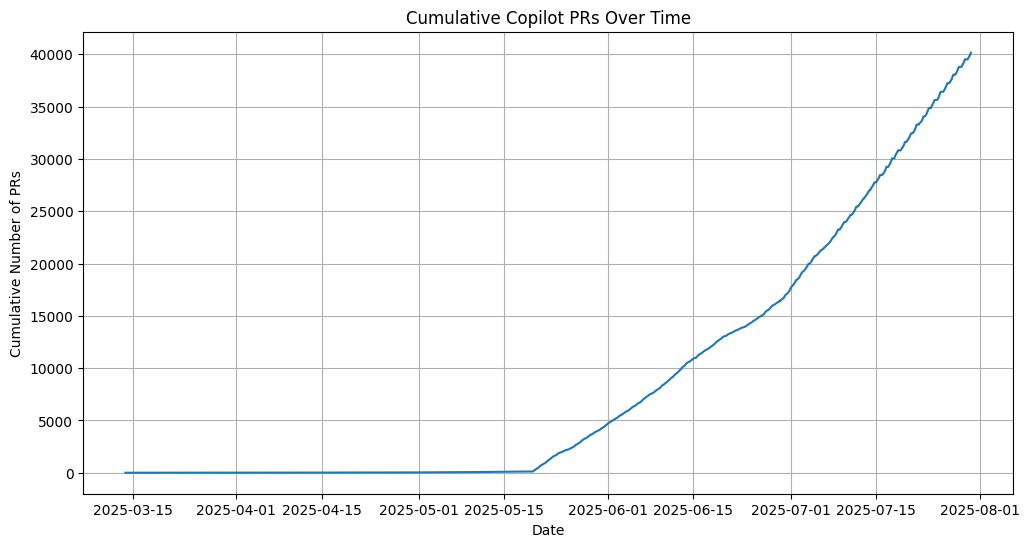

In [339]:
# Ensure 'created_at' is datetime type
metrics['created_at'] = pd.to_datetime(metrics['created_at'])

# Filter for Copilot PRs
copilot_prs = metrics[metrics['agent'] == 'Copilot'].copy()

# Sort by creation date
copilot_prs = copilot_prs.sort_values('created_at')

# Calculate cumulative count
copilot_prs['cumulative_prs'] = range(1, len(copilot_prs) + 1)

# Plot cumulative PRs over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=copilot_prs, x='created_at', y='cumulative_prs')
plt.title('Cumulative Copilot PRs Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of PRs')
plt.grid(True)
plt.show()

### Proportion of Copilot PRs per repository

In [ ]:
# Calculate the total number of PRs per repository
total_prs_per_repo = metrics.groupby('repo_id').size().reset_index(name='total_prs')

# Calculate the number of Copilot PRs per repository
copilot_prs_per_repo = metrics[metrics['isGeneratedByCopilot'] == True].groupby('repo_id').size().reset_index(name='copilot_prs')

# Merge the two dataframes
repo_prs_summary = pd.merge(total_prs_per_repo, copilot_prs_per_repo, on='repo_id', how='left').fillna(0)

# Calculate the proportion of Copilot PRs
repo_prs_summary['copilot_proportion'] = repo_prs_summary['copilot_prs'] / repo_prs_summary['total_prs']

# Sort by proportion for better visualization
repo_prs_summary = repo_prs_summary.sort_values('copilot_proportion', ascending=False)

# Plot the proportion of Copilot PRs per repository (showing top N or a distribution)
plt.figure(figsize=(12, 6))
sns.histplot(repo_prs_summary['copilot_proportion'], bins=20)
plt.title('Distribution of Copilot PR Proportion Per Repository')
plt.xlabel('Proportion of Copilot PRs')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

# Display summary statistics for the proportion
print("\nSummary statistics for Copilot PR proportion per repository:")
display(repo_prs_summary['copilot_proportion'].describe())

# Display the top 10 repositories with the highest proportion of Copilot PRs
print("\nTop 10 repositories by proportion of Copilot PRs:")
display(repo_prs_summary.head(10))

# **Sixth**, Causal Inference (RQ2)

### Propensity‑Score Estimation
Logistic regression (treatment = Copilot usage) on the 17 covariates.
Estimated each PR’s probability of receiving the treatment (ps).
### Weight Construction
Inverse‑probability weights: 1/ps for treated, 1/(1‑ps) for control.
### Entropy Balancing
Applied the entropy‑balancing algorithm (equivalent to R’s ebalance) to adjust the raw weights so that the weighted means of all covariates matched exactly between groups.
After balancing, absolute mean differences for every covariate were ≤ 0.10 (Fig. 2).
### Outcome Regression
* Review time (continuous): weighted ordinary least squares (lm analogue) with only the treatment indicator. The coefficient gave the Average Treatment Effect on the Treated (ATT) of ‑19.3 h (p ≈ 1.6 × 10⁻¹⁷).
* Merge outcome (binary): weighted logistic regression (glm with logit link). The exponentiated treatment coefficient yielded an odds ratio of 1.57 (95 % CI [1.35, 1.84], p < 0.001).
These two models answer RQ2.1 (review‑time reduction) and RQ2.2 (higher merge likelihood).


# The R Scripts
The main difference between PMW_merge.R and PMW_review.R is:

* PMW_merge.R includes the column isMerged, which indicates whether each pull request was merged (state == "MERGED"). This column is added to the modeling data and used in the analysis.
* PMW_review.R does not include the isMerged column in its modeling data; it focuses only on review-related metrics.
* Otherwise, both scripts process the same input data, use similar covariates, and prepare for causal inference analysis. The inclusion of isMerged in PMW_merge.R allows for analysis related to PR merge status, while PMW_review.R is focused on review characteristics.